# 5. Классификация текстов при помощи сетей прямого распространения

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г.

In [161]:
import re
import string
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nltk.corpus import stopwords, wordnet
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, random_split, DataLoader

In [130]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [131]:
DATA_DIR = Path("data/")

## 1. Представление и предобработка текстовых данных 

1.1 Операции по предобработке:
* токенизация
* стемминг / лемматизация
* удаление стоп-слов
* удаление пунктуации
* приведение к нижнему регистру
* любые другие операции над текстом

In [132]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

Реализовать функцию `preprocess_text(text: str) -> str`, которая:
* приводит строку к нижнему регистру
* заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел


In [133]:
def get_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def preprocess_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z.!?]", repl=" ", string=text, flags=re.MULTILINE)

    punctuation = set(string.punctuation)
    stop_words = set(stopwords.words("english"))
    lemmatizer = nltk.WordNetLemmatizer()

    sentences = []
    for sent in nltk.sent_tokenize(text):
        words = []
        for word in nltk.word_tokenize(sent):
            if word not in stop_words and word not in punctuation:
                lemma = lemmatizer.lemmatize(word, pos=get_pos(word))
                if lemma not in stop_words:
                    words.append(lemma)
        sentences.append(" ".join(words))

    text = ". ".join(sentences)
    text = re.sub(r"[!?]", repl=".", string=text, flags=re.MULTILINE)

    return text

In [134]:
preprocess_text(text)

'select preference run install command. stable represent currently test support version pytorch. note libtorch available c'

1.2 Представление текстовых данных при помощи бинарного кодирования


Представить первое предложение из `text` в виде тензора `sentence_t`: `sentence_t[i] == 1`, если __слово__ с индексом `i` присутствует в предложении.

In [135]:
text_ = preprocess_text(text)

alphabet = list(set(nltk.word_tokenize(text_)) - {"."})
word_to_idx = {word: i for i, word in enumerate(alphabet)}

sentence = nltk.sent_tokenize(text_)[0]
sentence = sentence[:-1] if sentence[-1] == '.' else sentence

sentence_t = torch.zeros(len(alphabet))
word_indices = [word_to_idx[w] for w in nltk.word_tokenize(sentence)]
sentence_t[word_indices] = 1
sentence_t

tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.])

## 2. Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`. 

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)

2.5 Реализовать класс `SurnamesDataset`

2.6. Обучить классификатор.

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

2.1 Считать файл `surnames/surnames.csv`.

In [136]:
surnames = pd.read_csv(DATA_DIR / "surnames.csv")
surnames.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


2.2 Закодировать национальности числами, начиная с 0.

In [137]:
labeler = LabelEncoder()
surnames["target"] = labeler.fit_transform(surnames["nationality"])
print(f"classes: {len(labeler.classes_)}")
surnames.head()

classes: 18


,surname,nationality,target
0,Woodford,English,4
1,Coté,French,5
2,Kore,English,4
3,Koury,Arabic,0
4,Lebzak,Russian,14


2.4 Реализовать класс `Vocab` (токен = __символ__)

In [138]:
class Vocab:

    def __init__(self, data: t.Iterable[str]):
        self.idx_to_token = list({ch for w in data for ch in w.lower()})
        self.token_to_idx = {t: i for i, t in enumerate(self.idx_to_token)}
        self.vocab_len = len(self.idx_to_token)

In [139]:
vocab = Vocab(surnames["surname"])
vocab.vocab_len

55

2.5 Реализовать класс `SurnamesDataset`

In [140]:
class SurnamesDataset(Dataset):
    def __init__(self, data: list[str], targets: torch.Tensor, vocab: Vocab):
        self.data = data
        self.targets = targets
        self.vocab = vocab

    def vectorize(self, surname: str) -> torch.Tensor:
        vec = torch.zeros(self.vocab.vocab_len)
        indices = [self.vocab.token_to_idx[t] for t in surname.lower()]
        vec[indices] = 1
        return vec

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.vectorize(self.data[idx]), self.targets[idx]


In [141]:
surnames_dataset = SurnamesDataset(
    data=surnames["surname"].tolist(),
    targets=torch.tensor(surnames["target"], dtype=torch.long),
    vocab=vocab,
)

2.3 Разбить датасет на обучающую и тестовую выборку

In [142]:
train_size = round(0.8 * len(surnames_dataset))
test_size = len(surnames_dataset) - train_size
train_dataset, test_dataset = random_split(surnames_dataset, lengths=(train_size, test_size))
len(train_dataset), len(test_dataset)

(8784, 2196)

2.6. Обучить классификатор.

In [203]:
def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        train_dataloader: DataLoader,
        epochs: int,
        verbose: int = 100,
        test_dataloader: DataLoader = None,
) -> t.List[float]:
    train_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, verbose)
        train_losses.append(train_loss.item())
        if test_dataloader:
            test_loop(test_dataloader, model, loss_fn)
        torch.cuda.empty_cache()
    return train_losses


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return avg_loss / num_batches


def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            avg_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy


def plot_losses(losses):
    plt.plot(torch.arange(len(losses)), losses)

In [215]:
class SurnamesClassifier(nn.Module):

    def __init__(self, in_features, out_features):
        super(SurnamesClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, out_features),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, inputs):
        return self.seq(inputs)

In [216]:
torch.manual_seed(0)

net = SurnamesClassifier(vocab.vocab_len, vocab.vocab_len)
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=512)

In [217]:
train_losses = common_train(
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    epochs=20,
    verbose=300,
    test_dataloader=test_dataloader,
)

Epoch 1
--------------------------------
loss: 4.025674  [    0/ 8784]
loss: 1.504290  [ 2400/ 8784]
loss: 2.591120  [ 4800/ 8784]
loss: 0.831439  [ 7200/ 8784]
Test Error: 
 Accuracy: 0.516849, Avg loss: 1.535508 

Epoch 2
--------------------------------
loss: 2.084085  [    0/ 8784]
loss: 1.354316  [ 2400/ 8784]
loss: 2.501081  [ 4800/ 8784]
loss: 0.754960  [ 7200/ 8784]
Test Error: 
 Accuracy: 0.562842, Avg loss: 1.413391 

Epoch 3
--------------------------------
loss: 2.004786  [    0/ 8784]
loss: 1.274540  [ 2400/ 8784]
loss: 2.525339  [ 4800/ 8784]
loss: 0.696974  [ 7200/ 8784]
Test Error: 
 Accuracy: 0.582878, Avg loss: 1.345605 

Epoch 4
--------------------------------
loss: 1.941258  [    0/ 8784]
loss: 1.186505  [ 2400/ 8784]
loss: 2.545471  [ 4800/ 8784]
loss: 0.653208  [ 7200/ 8784]
Test Error: 
 Accuracy: 0.594718, Avg loss: 1.301452 

Epoch 5
--------------------------------
loss: 1.908206  [    0/ 8784]
loss: 1.098935  [ 2400/ 8784]
loss: 2.564220  [ 4800/ 8784]
loss:

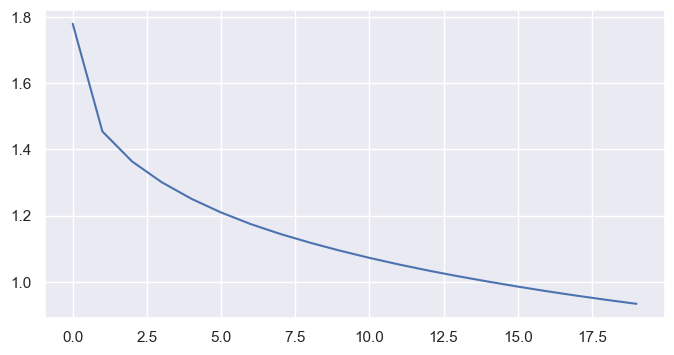

In [218]:
plot_losses(train_losses)

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [219]:
test_loop(dataloader=test_dataloader, model=net, loss_fn=loss_fn);

Test Error: 
 Accuracy: 0.640710, Avg loss: 1.180295 



In [220]:
k = 3
for i in range(10):
    x_test, y_test = test_dataset[i]

    pred = net(x_test.unsqueeze(0))
    pred_proba, pred_label_indices = F.softmax(pred, 1).topk(k, dim=1)
    pred_labels = labeler.inverse_transform(pred_label_indices.squeeze())

    predicts = ", ".join(
        [f"{label} ({prob:.2f})" for (label, prob) in zip(pred_labels, pred_proba.squeeze())]
    )
    print(f"Surname : {test_dataset.dataset.data[i]}")
    print(f"True    : {labeler.inverse_transform(y_test.unsqueeze(0))[0]}")
    print(f"Predicts: {predicts}\n")

Surname : Woodford
True    : Arabic
Predicts: Arabic (0.50), English (0.40), Irish (0.03)

Surname : Coté
True    : Russian
Predicts: Spanish (0.43), Italian (0.26), Russian (0.14)

Surname : Kore
True    : Russian
Predicts: Russian (0.76), English (0.11), Japanese (0.09)

Surname : Koury
True    : Greek
Predicts: English (0.71), Greek (0.08), Spanish (0.06)

Surname : Lebzak
True    : Vietnamese
Predicts: German (0.35), Russian (0.29), Czech (0.11)

Surname : Obinata
True    : English
Predicts: English (0.79), Czech (0.13), Dutch (0.04)

Surname : Rahal
True    : Czech
Predicts: English (0.90), Czech (0.08), Polish (0.01)

Surname : Zhuan
True    : German
Predicts: German (0.20), English (0.18), Italian (0.11)

Surname : Acconci
True    : Greek
Predicts: English (0.43), German (0.11), Czech (0.10)

Surname : Mifsud
True    : Arabic
Predicts: Arabic (0.71), Japanese (0.18), English (0.06)



## 3. Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g

3.1 Считать файл `yelp/raw_train.csv`. Оставить от исходного датасета 10% строчек.

3.2 Воспользоваться функцией `preprocess_text` из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

3.3 Разбить датасет на обучающую и тестовую выборку

3.4 Реализовать класс `Vocab` (токен = слово)

3.5 Реализовать класс `ReviewDataset`

3.6 Обучить классификатор

3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)


In [149]:
class Vocab:
    def __init__(self, data):
        self.idx_to_token = ...
        self.token_to_idx = ...
        self.vocab_len = ...

In [150]:
class ReviewDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, review):
        '''Генерирует представление отзыва review при помощи бинарного кодирования (см. 1.2)'''

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return ...